Title

brief explanation 

toc

In [1]:
%load_ext rpy2.ipython  

In [39]:
%%R
library(dplyr)
library(stringr)
library(ggplot2)
library(viridis)
library(GenomicRanges)
library(ggpubr)
library(corrplot)
library(ggpubr)

In [39]:
# library(chromVAR) 
# library(DESeq2)

R[write to console]: corrplot 0.92 loaded



### 1. Data and task

built on ChromID paper



In [45]:
import pandas as pd

df = pd.read_csv("polybox/ChromID_raw_sequencing_files_list.csv", header=None, sep="\t")

for row in range(len(df)):
    row = df.iloc[row]
    row = row.to_string(index=False)
    row_list = row.strip().split(',')
    print(row_list)

['GSM3688213', 'MmES_TAF3_2xPhd_r1', 'SRR8788896']
['GSM3688214', 'MmES_TAF3_2xPhd_r2', 'SRR8788897']
['GSM3688196', 'MmES_bioGFP_r1', 'SRR8788879']
['GSM3688197', 'MmES_bioGFP_r2', 'SRR8788880']
['GSM3688198', 'MmES_H3K27me3', 'SRR8788881']
['GSM3688199', 'MmES_H3K4me3', 'SRR8788882']
['GSM3688201', 'MmES_MBD1_MBD', 'SRR8788884']


In [17]:
mapping = {
'SRR8788879':'bioGFP_r1',  
'SRR8788880':'bioGFP_r2',
'SRR8788896':'TAF3_2xPhd_r1',
'SRR8788897':'TAF3_2xPhd_r2',
'SRR8788884':'MBD1_MBD',     
'SRR8788881':'H3K27me3',     
'SRR8788882':'H3K4me3'
}

In [44]:
%%bash 
# download data
data_folder='/network/projects/_groups/grn_control/bow/NanoTag/nanotag/data'
cd $data_folder
pwd
for sra in SRR8788896 SRR8788897 SRR8788879 SRR8788880 SRR8788881 SRR8788882 SRR8788884; do
    echo "downloading..."$sra;
    prefetch $sra
    echo "splitting paired reads..."
    fastq-dump --split-3 $sra --outdir $sra/
done

/network/projects/_groups/grn_control/bow/NanoTag/nanotag/data
downloading...SRR8788896

splitting paired reads...
Rejected 50336912 READS because of filtering out non-biological READS
Read 50336912 spots for SRR8788896
Written 50336912 spots for SRR8788896
downloading...SRR8788897

splitting paired reads...
Rejected 46843195 READS because of filtering out non-biological READS
Read 46843195 spots for SRR8788897
Written 46843195 spots for SRR8788897
downloading...SRR8788879

splitting paired reads...
Read 58455988 spots for SRR8788879
Written 58455988 spots for SRR8788879
downloading...SRR8788880

splitting paired reads...
Read 37303595 spots for SRR8788880
Written 37303595 spots for SRR8788880
downloading...SRR8788881

splitting paired reads...
Rejected 51613505 READS because of filtering out non-biological READS
Read 51613505 spots for SRR8788881
Written 51613505 spots for SRR8788881
downloading...SRR8788882

splitting paired reads...
Rejected 44602665 READS because of filtering out n

2022-12-03T15:05:05 prefetch.3.0.1: Current preference is set to retrieve SRA Normalized Format files with full base quality scores.
2022-12-03T15:05:06 prefetch.3.0.1: 1) Downloading 'SRR8788896'...
2022-12-03T15:05:06 prefetch.3.0.1: SRA Normalized Format file is being retrieved, if this is different from your preference, it may be due to current file availability.
2022-12-03T15:05:06 prefetch.3.0.1:  Downloading via HTTPS...
2022-12-03T15:06:06 prefetch.3.0.1:  HTTPS download succeed
2022-12-03T15:06:12 prefetch.3.0.1:  'SRR8788896' is valid
2022-12-03T15:06:12 prefetch.3.0.1: 1) 'SRR8788896' was downloaded successfully
2022-12-03T15:06:12 prefetch.3.0.1: 'SRR8788896' has 0 unresolved dependencies
2022-12-03T15:10:24 prefetch.3.0.1: Current preference is set to retrieve SRA Normalized Format files with full base quality scores.
2022-12-03T15:10:24 prefetch.3.0.1: 1) Downloading 'SRR8788897'...
2022-12-03T15:10:24 prefetch.3.0.1: SRA Normalized Format file is being retrieved, if this

In [46]:
%%bash
data_folder='/network/projects/_groups/grn_control/bow/NanoTag/nanotag/data'
cd $data_folder
pwd
for sra in SRR8788896 SRR8788897 SRR8788879 SRR8788880 SRR8788881 SRR8788882 SRR8788884; do
    mv $sra".fastq" $sra/
done

/network/projects/_groups/grn_control/bow/NanoTag/nanotag/data


In [14]:
root="/network/projects/_groups/grn_control/bow/NanoTag/nanotag"

In [ ]:
# rename reads files
import os

for (dirpath, dirnames, filenames) in os.walk(os.path.join(root,'data/reads')):
    for file in filenames:
        if file.endswith(".fastq"):
            sra, _ = file.strip().split('.')
            id_sample = mapping[sra]
            
            new_filename = f"{dirpath}/{id_sample}.fastq"
            cmd = f"mv {dirpath}/{file} {new_filename}"
            print(cmd)
            os.system(cmd)

In [4]:
!pwd
!mkdir -p data/reads
!mv data/SRR* data/reads

/network/projects/grn_control/bow/NanoTag/nanotag


In [ ]:
!mkdir -p raw-fastqc

import os

for (dirpath, dirnames, filenames) in os.walk(os.path.join(root,'data/reads')):
    for file in filenames:
        if file.endswith(".fastq"):
            filepath = os.path.join(dirpath, file)
            cmd = f"fastqc -o {root}/raw-fastqc --threads 32 {filepath}"
            # print(cmd)
            os.system(cmd)
            
            
# or in bash
!for file in data/reads/*/*.fastq; do echo $file && fastqc -o raw-fastqc/ --threads 32 $file ; done

In [18]:
!cd raw-fastqc/ && multiqc .


  /// ]8;id=669245;https://multiqc.info\MultiQC]8;;\ 🔍 | v1.13

|           multiqc | Search path : /network/projects/grn_control/bow/NanoTag/nanotag/raw-fastqc
|         searching | ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100% 14/14  stqc.htmlF3_2xPhd_r1_fastqc.html
|            fastqc | Found 7 reports
|           multiqc | Compressing plot data
|           multiqc | Report      : multiqc_report.html
|           multiqc | Data        : multiqc_data
|           multiqc | MultiQC complete


## Downsample (later use)

In [68]:
%%bash

# downsampled-reads=data/downsampled-reads
mkdir -p data/downsampled-reads
# mv data/data/reads/downsampled-reads data/

mkdir
for f in data/reads/*/*.fastq;
do
    echo "downsampling" $f
    save_to=${f##*/}
    
    # echo "tot reads:"
    # grep '@' $f | wc -l
    
    /home/mila/i/ionelia.buzatu/bow/programs/seqtk/seqtk sample -s100 $f 7000000 > data/downsampled-reads/$save_to
    
done   

downsampling data/reads/SRR8788879/bioGFP_r1.fastq
downsampling data/reads/SRR8788880/bioGFP_r2.fastq
downsampling data/reads/SRR8788881/H3K27me3.fastq
downsampling data/reads/SRR8788882/H3K4me3.fastq
downsampling data/reads/SRR8788884/MBD1_MBD.fastq
downsampling data/reads/SRR8788896/TAF3_2xPhd_r1.fastq
downsampling data/reads/SRR8788897/TAF3_2xPhd_r2.fastq


mkdir: missing operand
Try 'mkdir --help' for more information.


## Trimming

In [20]:
!mkdir -p trim-galore
!for i in data/reads/*/*.fastq; \
    do /home/mila/i/ionelia.buzatu/bow/programs/TrimGalore-0.6.6/trim_galore -o trim-galore --cores 32 $i; done

Using an excessive number of cores has a diminishing return! It is recommended not to exceed 8 cores per trimming process (you asked for 32 cores). Please consider re-specifying
Path to Cutadapt set as: 'cutadapt' (default)
Cutadapt seems to be working fine (tested command 'cutadapt --version')
Cutadapt version: 4.1
Cutadapt seems to be using Python 3! Proceeding with multi-core enabled Cutadapt using 32 cores
Proceeding with 'gzip' for compression. PLEASE NOTE: Using multi-cores for trimming with 'gzip' only has only very limited effect! (see here: https://github.com/FelixKrueger/TrimGalore/issues/16#issuecomment-458557103)
To increase performance, please install 'pigz' and run again

No quality encoding type selected. Assuming that the data provided uses Sanger encoded Phred scores (default)

Output will be written into the directory: /network/projects/grn_control/bow/NanoTag/nanotag/trim-galore/


AUTO-DETECTING ADAPTER TYPE
Attempting to auto-detect adapter type from the first 1 mi

## . Alignment 

In [ ]:
(bowtie2 -p 32 -x ../epibioinfo/week03/mm_genome/bowtie2 -U Setup/data/trim_galore/ctr_trimmed.fq) 2> Setup/data/aligned/ctr.bowtie2 |\
  samtools view -bS - | samtools sort -@4 -m 2G - > Setup/data/aligned/ctr.bam
samtools index aligned/ctr.bam

In [76]:
%%bash

mkdir -p ./data/aligned/sam
mkdir -p ./data/aligned/bam
mkdir -p ./data/aligned/bed
mkdir -p ./data/aligned/bedgraph
mkdir -p ./data/aligned/bigwig
mkdir -p ./data/aligned/logs

mm10_index_file='/network/projects/_groups/grn_control/bow/bowtie2/mm10/mm10'
root="/network/projects/_groups/grn_control/bow/NanoTag/nanotag"

for i in SRR8788879,bioGFP_r1 SRR8788880,bioGFP_r2 SRR8788896,TAF3_2xPhd_r1 SRR8788897,TAF3_2xPhd_r2 SRR8788884,MBD1_MBD; do
    IFS=","; set -- $i; 
    sra=$1
    id_name=$2
    echo doing: ${id_name}
    
    trimmed_fastq_file=${root}/trim-galore/${id_name}_trimmed.fq
    output_sam_file=${root}/data/aligned/sam/${id_name}_bowtie2.sam
    stdout_file=${root}/data/aligned/logs/${id_name}_bowtie2.txt
    
    mapped_bam=${root}/data/aligned/bam/${id_name}.bowtie2.mapped.bam
    sorted_bam_output=${root}/data/aligned/bam/${id_name}.bowtie2.sorted.bam
    # bigwig_file_output=$root_path$sra"/alignment/bigwig/"$id_name"_raw.bw" 
    
    # echo ${id_name}': alignment to reference'
    # bowtie2 -p 32 -x $mm10_index_file -U $trimmed_fastq_file -S $output_sam_file > $stdout_file
    
    # echo "convert sam to bam"
    # samtools view -bS $output_sam_file >$mapped_bam
    
    echo "sort and index bam"
    # cat $output_sam_file | samtools view -bS - | 
    samtools sort -@32 -m 5G -O bam -o $sorted_bam_output $output_sam_file
    samtools index $sorted_bam_output
    
    
    # echo "Convert into bed file format"
    # bedtools bamtobed -i $mapped_bam -bedpe >$bed_file
    
    # bamCoverage -b $sorted_bam_output -o $bigwig_file_output --numberOfProcessors $cores 
    
done    

doing: bioGFP_r1
sort and index bam


[bam_sort_core] merging from 0 files and 32 in-memory blocks...


### Sequencing depth stats table

In [33]:
%%R

library(magrittr) # needs to be run every time you start R and want to use %>%
library(dplyr)

projPath = "/network/projects/_groups/grn_control/bow/NanoTag/nanotag"

samples_list_path = c('bioGFP_r1', 'bioGFP_r2', 'TAF3_2xPhd_r1', 'TAF3_2xPhd_r2', 'MBD1_MBD')
samples_list_for_rep = c('bioGFP_r1', 'bioGFP_r2', 'TAF3_r1', 'TAF3_r2', 'MBD1_r1')
tuple_samples = mapply(c, samples_list_path, samples_list_for_rep, SIMPLIFY = FALSE)

## Collect the alignment results from the bowtie2 alignment summary files
alignResult = c()

for(pair in tuple_samples){
    hist = pair[1]
    rep = pair[2]
    path_txt = paste0(projPath, "/data/aligned/logs/", hist, "_bowtie2.txt") 
    alignRes = read.table(path_txt, header = FALSE, fill = TRUE)
    alignRate = substr(alignRes$V1[6], 1, nchar(as.character(alignRes$V1[6]))-1)
    histInfo = strsplit(rep, "_")[[1]]
    alignResult = data.frame(Residue = histInfo[1], Replicate = histInfo[2], 
                             SeqDepth = alignRes$V1[1] %>% as.character %>% as.numeric, 
                             MappedFragNum_mm10 = alignRes$V1[4] %>% as.character %>% as.numeric + alignRes$V1[5] 
                             %>% as.character %>% as.numeric, 
                             AlignRatEmm10 = alignRate %>% as.numeric)  %>% rbind(alignResult, .)
}

#alignResult$Histone = factor(alignResult$Residue, levels = samples_list)
alignResult = alignResult %>% mutate(AlignRatEmm10 = paste0(AlignRatEmm10, "%"))
write.csv(alignResult,"csvs/alignResult.csv", row.names = FALSE)
alignResult

  Residue Replicate SeqDepth MappedFragNum_mm10 AlignRatEmm10
1  bioGFP        r1 57904904           56859606        98.19%
2  bioGFP        r2 36137591           35427017        98.03%
3    TAF3        r1 50305015           49586494        98.57%
4    TAF3        r2 46839861           46297475        98.84%
5    MBD1        r1 40080359           39256476        97.94%


In [ ]:
visualize alignment stats

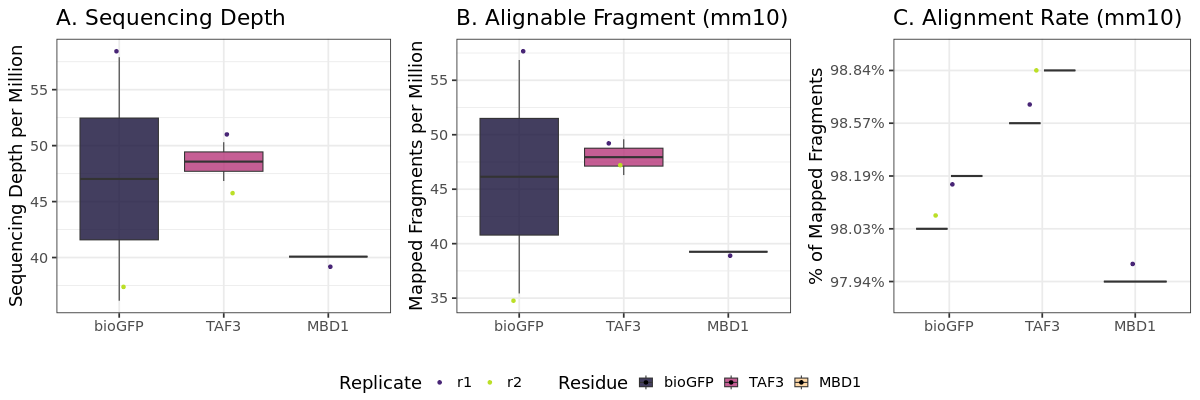

In [57]:
%%R -w 1200 -h 400

## Generate sequencing depth boxplot
fig3A = alignResult %>% ggplot(aes(x = Residue, y = SeqDepth/1000000, fill = Residue)) +
    geom_boxplot() +
    geom_jitter(aes(color = Replicate), position = position_jitter(0.15)) +
    scale_fill_viridis(discrete = TRUE, begin = 0.1, end = 0.9, option = "magma", alpha = 0.8) +
    scale_color_viridis(discrete = TRUE, begin = 0.1, end = 0.9) +
    theme_bw(base_size = 18) +
    ylab("Sequencing Depth per Million") +
    xlab("") + 
    ggtitle("A. Sequencing Depth")
    
fig3B = alignResult %>% ggplot(aes(x = Residue, y = MappedFragNum_mm10/1000000, fill = Residue)) +
    geom_boxplot() +
    geom_jitter(aes(color = Replicate), position = position_jitter(0.15)) +
    scale_fill_viridis(discrete = TRUE, begin = 0.1, end = 0.9, option = "magma", alpha = 0.8) +
    scale_color_viridis(discrete = TRUE, begin = 0.1, end = 0.9) +
    theme_bw(base_size = 18) +
    ylab("Mapped Fragments per Million") +
    xlab("") +
    ggtitle("B. Alignable Fragment (mm10)")

fig3C = alignResult %>% ggplot(aes(x = Residue, y = AlignRatEmm10, fill = Residue)) +
    geom_boxplot() +
    geom_jitter(aes(color = Replicate), position = position_jitter(0.15)) +
    scale_fill_viridis(discrete = TRUE, begin = 0.1, end = 0.9, option = "magma", alpha = 0.8) +
    scale_color_viridis(discrete = TRUE, begin = 0.1, end = 0.9) +
    theme_bw(base_size = 18) +
    ylab("% of Mapped Fragments") +
    xlab("") +
    ggtitle("C. Alignment Rate (mm10)")
    


ggarrange(fig3A, fig3B, fig3C, ncol = 3, common.legend = TRUE, legend="bottom")    

In [78]:
!mkdir -p data/aligned/bam/sorted
!mv data/aligned/bam/*bowtie2* data/aligned/bam/sorted/

In [91]:
!mkdir -p data/aligned/bam/indexed/marking_metrics

In [95]:
%%bash

for f in data/aligned/bam/sorted/*bowtie2.sorted.bam;

do

    tmp=${f##*/}
    name=${tmp%.bam}
    dup=data/aligned/bam/indexed/tmp/$name.bam    
    echo name: $name
          
    # java -XX:ParallelGCThreads=8 -jar /home/mila/i/ionelia.buzatu/comp-venv/bin/picard.jar MarkDuplicates \
      #     -I $f -O $dup -M data/aligned/bam/indexed/marking_metrics/metrics_$name.txt
    
    echo "filtered $name"
    bedtools intersect -v -a $dup -b blacklist/*.bed | samtools view -h -b --threads 20 -q 30 -F 0x4 | \
     samtools view -h --threads 20 | egrep -v chrM | samtools view -b -h --threads 20 > data/aligned/bam/indexed/$name-ind.bam
    
    
    # echo "indexed $name"
    # samtools index -b data/aligned/bam/indexed/$name-ind.bam
          
    break
done

all: bioGFP_r1.bowtie2.sorted.bam bioGFP_r1.bowtie2.sorted data/aligned/bam/indexed/tmp
dup: data/aligned/bam/indexed/tmp
file: data/aligned/bam/sorted/bioGFP_r1.bowtie2.sorted.bam
name: bioGFP_r1.bowtie2.sorted


bash: line 19: java: command not found


### Merge replicates

In [130]:
%%bash

root_sorted=data/aligned/bam/sorted
root_merged=data/aligned/bam/merged

samtools merge -o $root_merged/bioGFP_merged.bam \
    $root_sorted/bioGFP_r1.bowtie2.sorted.bam $root_sorted/bioGFP_r2.bowtie2.sorted.bam

samtools merge -o $root_merged/TAF3_2xPhd_merged.bam \
    $root_sorted/TAF3_2xPhd_r1.bowtie2.sorted.bam $root_sorted/TAF3_2xPhd_r2.bowtie2.sorted.bam # not done this yet!

### Peak calling

In [96]:
%%bash

mkdir -p data/peaks

macs2 callpeak --nomodel --broad --nolambda --outdir peaks -n ctr --gsize mm -t data/aligned/bam/sorted/bioGFP_r1.bowtie2.sorted.bam

macs2 callpeak --nomodel --broad --nolambda --outdir peaks \
    -c data/aligned/bam/sorted/bioGFP_r1.bowtie2.sorted.bam -n MBD1 --gsize mm \ 
    -t data/aligned/bam/sorted/MBD1_MBD.bowtie2.sorted.bam

macs2 callpeak --nomodel --broad --nolambda --outdir peaks \
    -c data/aligned/bam/sorted/bioGFP_r1.bowtie2.sorted.bam \
    -t data/aligned/bam/sorted/TAF3_2xPhd_r1.bowtie2.sorted.bam\
    -n TAF3_2xPhd_r1 \
    --gsize mm

macs2 callpeak --nomodel --broad --nolambda --outdir peaks \
    -c data/aligned/bam/sorted/bioGFP_r1.bowtie2.sorted.bam \
    -t data/aligned/bam/sorted/TAF3_2xPhd_r2.bowtie2.sorted.bam\
    -n TAF3_2xPhd_r2 \
    --gsize mm

macs2 callpeak --nomodel --broad --nolambda --outdir peaks \
    -c data/aligned/bam/sorted/bioGFP_r1.bowtie2.sorted.bam \
    -t data/aligned/bam/merged/TAF3_2xPhd_merged.bowtie2.sorted.bam\
    -n TAF3_2xPhd_merged \
    --gsize mm

INFO  @ Thu, 08 Dec 2022 10:25:24: 
# Command line: callpeak --nomodel --broad --nolambda --outdir peaks -n ctr --gsize mm -t data/aligned/bam/sorted/bioGFP_r1.bowtie2.sorted.bam
# ARGUMENTS LIST:
# name = ctr
# format = AUTO
# ChIP-seq file = ['data/aligned/bam/sorted/bioGFP_r1.bowtie2.sorted.bam']
# control file = None
# effective genome size = 1.87e+09
# band width = 300
# model fold = [5, 50]
# qvalue cutoff for narrow/strong regions = 5.00e-02
# qvalue cutoff for broad/weak regions = 1.00e-01
# The maximum gap between significant sites is assigned as the read length/tag size.
# The minimum length of peaks is assigned as the predicted fragment length "d".
# Larger dataset will be scaled towards smaller dataset.
# Range for calculating regional lambda is: 10000 bps
# Broad region calling is on
# Paired-End mode is off
 
INFO  @ Thu, 08 Dec 2022 10:25:24: #1 read tag files... 
INFO  @ Thu, 08 Dec 2022 10:25:24: #1 read treatment tags... 
INFO  @ Thu, 08 Dec 2022 10:25:24: Detected fo

In [98]:
!head -n 5 peaks/ctr_r1_peaks.broadPeak

chr1	3062602	3062942	ctr_peak_1	15	.	2.53913	3.93953	1.51545
chr1	3670651	3671906	ctr_peak_2	29	.	3.01442	5.65438	2.93552
chr1	3672300	3672531	ctr_peak_3	10	.	2.33627	3.28625	1.01465
chr1	3681559	3681779	ctr_peak_4	24	.	2.89202	5.15935	2.49879
chr1	3956107	3956512	ctr_peak_5	13	.	2.49102	3.77651	1.38572


### Compare peaks

`pip install intervene`

In [ ]:
Extra: converge mm9 to mm10 author wig files
    
1. `wig2bed < GSM3688213_MmES_Taf3.2xPHD_r1.wig > GSM3688213_MmES_Taf3.2xPHD_r1.bed`    
2. `liftOver input.bed hg18To19.chain output.bed unlifted.bed`

In [102]:
!ls /home/mila/i/ionelia.buzatu/bow/programs/liftOver

/home/mila/i/ionelia.buzatu/bow/programs/liftOver


In [110]:
!head ~/bow/NanoTag/nanotag/data/polybox/broadpeak_MBD1_MBD_combined_peaks.broadPeak

track type=broadPeak visibility=3 db=mm9 name="bPk_MBD1_MBD_combined"
chr1	3094027	3094149	broadpeak_MBD1_MBD_combined_peak_1	26	.	3.30103	4.98684	2.63410
chr1	3133266	3133479	broadpeak_MBD1_MBD_combined_peak_2	26	.	3.40388	4.96963	2.60208
chr1	3137736	3138096	broadpeak_MBD1_MBD_combined_peak_3	58	.	4.26055	8.78446	5.84496
chr1	3139970	3140237	broadpeak_MBD1_MBD_combined_peak_4	26	.	3.46830	5.07369	2.67202
chr1	3175184	3176058	broadpeak_MBD1_MBD_combined_peak_5	16	.	2.76230	3.71494	1.65355
chr1	3291488	3292099	broadpeak_MBD1_MBD_combined_peak_6	26	.	3.34735	4.97558	2.61615
chr1	3480425	3480643	broadpeak_MBD1_MBD_combined_peak_7	54	.	4.14862	8.40212	5.46188
chr1	3521638	3522010	broadpeak_MBD1_MBD_combined_peak_8	172	.	7.47457	21.54885	17.28264
chr1	3522578	3523898	broadpeak_MBD1_MBD_combined_peak_9	56	.	4.36288	8.51981	5.67470


### Convert boardPeak to bed

In [109]:
# convert authors files
dir="~/bow/NanoTag/nanotag/data/polybox"
sed '1d'!sed '1d' $dir/broadpeak_MBD1_MBD_combined_peaks.broadPeak | cut -f 1-3 > $dir/MBD1_MBD_combined_peaks.bed
!sed '1d' $dir/broadpeak_TAF3-2xPHD_combined_peaks.broadPeak | cut -f 1-3 > $dir/TAF3-2xPHD_combined_peaks.bed

In [136]:
%%bash
move_to=peaks/broadpeaks-to-bed
mkdir -p $move_to

for f in peaks/*peaks.broadPeak;
do
    bed_filepath=${move_to}/${f##*/}.bed
    echo $bed_filepath
    sed '1d' $f | cut -f 1-3 > $bed_filepath
done

peaks/broadpeaks-to-bed/ctr_r1_peaks.broadPeak.bed
peaks/broadpeaks-to-bed/MBD1_peaks.broadPeak.bed
peaks/broadpeaks-to-bed/TAF3_2xPhd_r1_peaks.broadPeak.bed


In [4]:
!sed '1d' peaks/TAF3_2xPhd_r2_peaks.broadPeak | cut -f 1-3 > peaks/broadpeaks-to-bed/TAF3_2xPhd_r2_peaks.broadPeak.bed

#### merge peak bed file for TAF3 (used to compare it with the author's)

In [34]:
!samtools merge -o peaks/broadpeaks-to-bed/TAF3_2xPhd_merged.bed \
    peaks/broadpeaks-to-bed/TAF3_2xPhd_r1_peaks.broadPeak.bed peaks/broadpeaks-to-bed/TAF3_2xPhd_r2_peaks.broadPeak.bed

In [35]:
!cat peaks/broadpeaks-to-bed/TAF3_2xPhd_r* | sort -k1,1 -k2,2n | bedtools merge -i - > taf3_merged.bed

### Convert author mm9 peak files to mm10 assembly bed files

In [113]:
liftover="/home/mila/i/ionelia.buzatu/bow/programs/liftOver"
mm9ToMm10_chain="/home/mila/i/ionelia.buzatu/bow/liftover-chains/mm9ToMm10.over.chain"

!$liftover $dir/MBD1_MBD_combined_peaks.bed $mm9ToMm10_chain \
    $dir/mm10/MBD1_MBD_combined_peaks_mm10_output.bed $dir/mm10/MBD1_MBD_combined_peaks_mm10_unlifted.bed

!$liftover $dir/TAF3-2xPHD_combined_peaks.bed \
    $mm9ToMm10_chain $dir/mm10/TAF3-2xPHD_combined_peak_mm10_output.bed $dir/mm10/TAF3-2xPHD_combined_peaks_mm10_unlifted.bed

Reading liftover chains
Mapping coordinates


## Genome Wide Coverage Plot

In [115]:
!mkdir -p bigwigs

In [124]:
%%bash
for f in data/aligned/bam/sorted/*bowtie2.sorted.bam; do
    
    name=${f##*/}
    echo $name
    bigwig_file_output=bigwigs/${name}.bw
    bamCoverage -b $f -o $bigwig_file_output --normalizeUsing RPGC --effectiveGenomeSize 2730871774 --numberOfProcessors 32
done    

bioGFP_r1.bowtie2.sorted.bam
bioGFP_r2.bowtie2.sorted.bam
MBD1_MBD.bowtie2.sorted.bam
TAF3_2xPhd_r1.bowtie2.sorted.bam
TAF3_2xPhd_r2.bowtie2.sorted.bam


normalization: 1x (effective genome size 2730871774)
bamFilesList: ['data/aligned/bam/sorted/bioGFP_r1.bowtie2.sorted.bam']
binLength: 50
numberOfSamples: None
blackListFileName: None
skipZeroOverZero: False
bed_and_bin: False
genomeChunkSize: None
defaultFragmentLength: read length
numberOfProcessors: 32
verbose: False
region: None
bedFile: None
minMappingQuality: None
ignoreDuplicates: False
chrsToSkip: []
stepSize: 50
center_read: False
samFlag_include: None
samFlag_exclude: None
minFragmentLength: 0
maxFragmentLength: 0
zerosToNans: False
smoothLength: None
save_data: False
out_file_for_raw_data: None
maxPairedFragmentLength: 1000
normalization: 1x (effective genome size 2730871774)
bamFilesList: ['data/aligned/bam/sorted/bioGFP_r2.bowtie2.sorted.bam']
binLength: 50
numberOfSamples: None
blackListFileName: None
skipZeroOverZero: False
bed_and_bin: False
genomeChunkSize: None
defaultFragmentLength: read length
numberOfProcessors: 32
verbose: False
region: None
bedFile: None
minMappi

In [7]:
%%bash
### bigwig of merged ctr 
samtools index -b data/aligned/bam/merged/bioGFP_merged.bam
bamCoverage -b data/aligned/bam/merged/bioGFP_merged.bam \
    -o bigwigs/bioGFP_merged.bw --normalizeUsing RPGC --effectiveGenomeSize 2730871774 --numberOfProcessors 32

normalization: 1x (effective genome size 2730871774)
bamFilesList: ['data/aligned/bam/merged/bioGFP_merged.bam']
binLength: 50
numberOfSamples: None
blackListFileName: None
skipZeroOverZero: False
bed_and_bin: False
genomeChunkSize: None
defaultFragmentLength: read length
numberOfProcessors: 32
verbose: False
region: None
bedFile: None
minMappingQuality: None
ignoreDuplicates: False
chrsToSkip: []
stepSize: 50
center_read: False
samFlag_include: None
samFlag_exclude: None
minFragmentLength: 0
maxFragmentLength: 0
zerosToNans: False
smoothLength: None
save_data: False
out_file_for_raw_data: None
maxPairedFragmentLength: 1000


## Fig. 1d

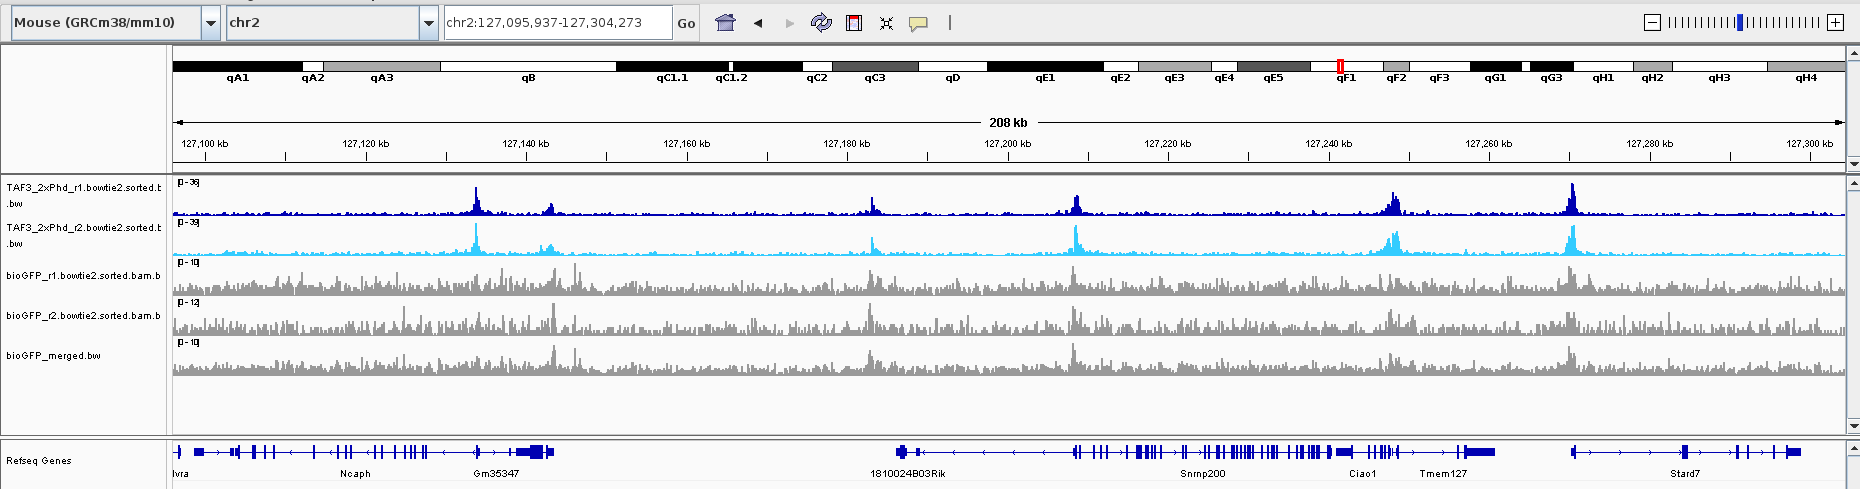

## Fig. 1f

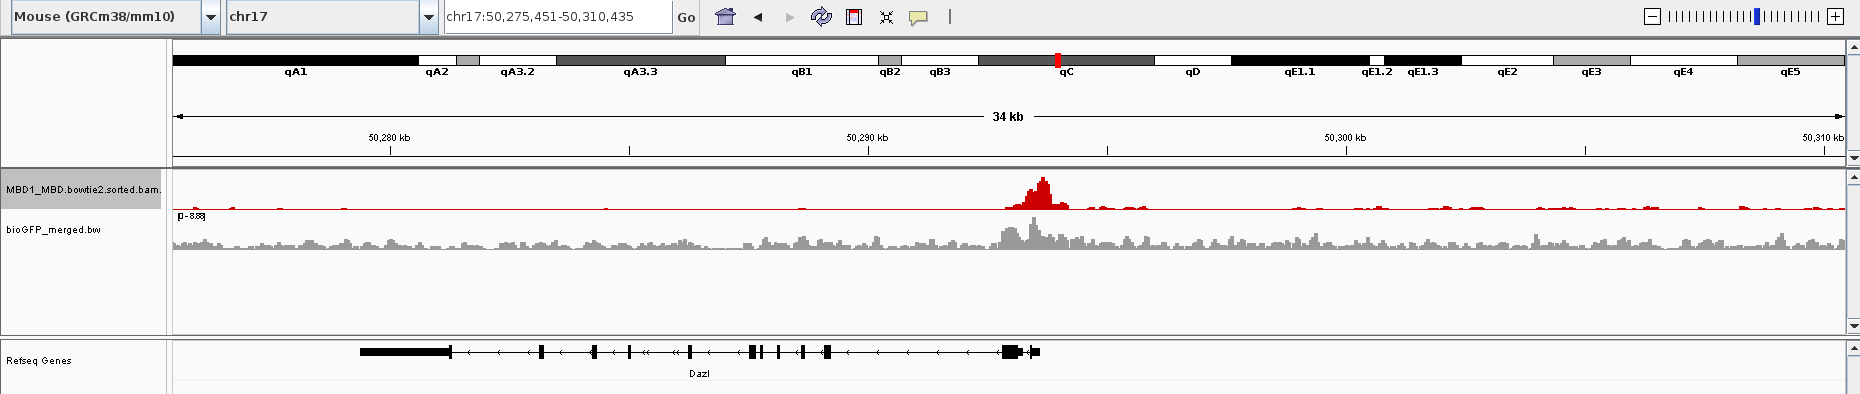

### Heapmap Chip-seq peaks

In [128]:
%%bash

mkdir -p matrix-genes/
bigwigs_root=bigwigs/
author_beds_root=/network/projects/_groups/grn_control/bow/NanoTag/nanotag/data/polybox/mm10/

computeMatrix reference-point \
    -S $bigwigs_root/bioGFP_r1.bowtie2.sorted.bam.bw \
    -R $author_beds_root/MBD1_MBD_combined_peaks_mm10_output.bed \
    --referencePoint center \
    -a 2000 \
    -b 2000 \
    --binSize 5 \
    -out matrix-genes/author_MBD1_MBD_combined_peaks_mm10.tab.gz -p 32


# reproduced
computeMatrix reference-point \
    -S bigwigs/bioGFP_r1.bowtie2.sorted.bam.bw \
    -R peaks/broadpeaks-to-bed/TAF3_2xPhd_r1_peaks.broadPeak.bed \
    --referencePoint center \
    -a 2000 \
    -b 2000 \
    --binSize 5 \
    -out matrix-genes/TAF3_2xPhd_r1.tab.gz -p 32

computeMatrix reference-point \
    -S bigwigs/bioGFP_r1.bowtie2.sorted.bam.bw \
    -R peaks/broadpeaks-to-bed/TAF3_2xPhd_r2_peaks.broadPeak.bed \
    --referencePoint center \
    -a 2000 \
    -b 2000 \
    --binSize 5 \
    -out matrix-genes/TAF3_2xPhd_r2.tab.gz -p 32

computeMatrix reference-point \
    -S bigwigs/bioGFP_r1.bowtie2.sorted.bam.bw \
    -R peaks/broadpeaks-to-bed/MBD1_peaks.broadPeak.bed \
    --referencePoint center \
    -a 2000 \
    -b 2000 \
    --binSize 5 \
    -out matrix-genes/MBD1_MBD.tab.gz -p 32

In [129]:
%%bash

mkdir -p heatmaps/peaks

plotHeatmap -m matrix-genes/author_MBD1_MBD_combined_peaks_mm10.tab.gz -out heatmaps/peaks/author_MBD1_MBD_combined_peaks_mm10.png \
    --heatmapHeight 15  \
    --refPointLabel peak.center \
    --regionsLabel peaks \
    --plotTitle 'author_MBD1_MBD_combined_peaks'

In [43]:
!plotHeatmap -m matrix-genes/MBD1_MBD.tab.gz -out heatmaps/peaks/MBD1_MBD.png \
    --heatmapHeight 15  \
    --refPointLabel peak.center \
    --regionsLabel peaks \
    --plotTitle 'MBD1_MBD'

In [39]:
!plotHeatmap -m matrix-genes/TAF3_2xPhd_r1.tab.gz -out heatmaps/peaks/TAF_2xPhd_r1.png \
    --heatmapHeight 15  \
    --refPointLabel peak.center \
    --regionsLabel peaks \
    --plotTitle 'TAF_2xPhd_r1'

In [40]:
!plotHeatmap -m matrix-genes/TAF3_2xPhd_r2.tab.gz -out heatmaps/peaks/TAF_2xPhd_r2.png \
    --heatmapHeight 15  \
    --refPointLabel peak.center \
    --regionsLabel peaks \
    --plotTitle 'TAF_2xPhd_r2'

/network/projects/_groups/grn_control/bow/NanoTag/nanotag/heatmaps/peaks//TAF_2xPhd_r1.png True
/network/projects/_groups/grn_control/bow/NanoTag/nanotag/heatmaps/peaks//TAF_2xPhd_r2.png True
/network/projects/_groups/grn_control/bow/NanoTag/nanotag/heatmaps/peaks//MBD1_MBD.png True
/network/projects/_groups/grn_control/bow/NanoTag/nanotag/heatmaps/peaks//MBD1_MBD_combined_peaks_mm10.png True


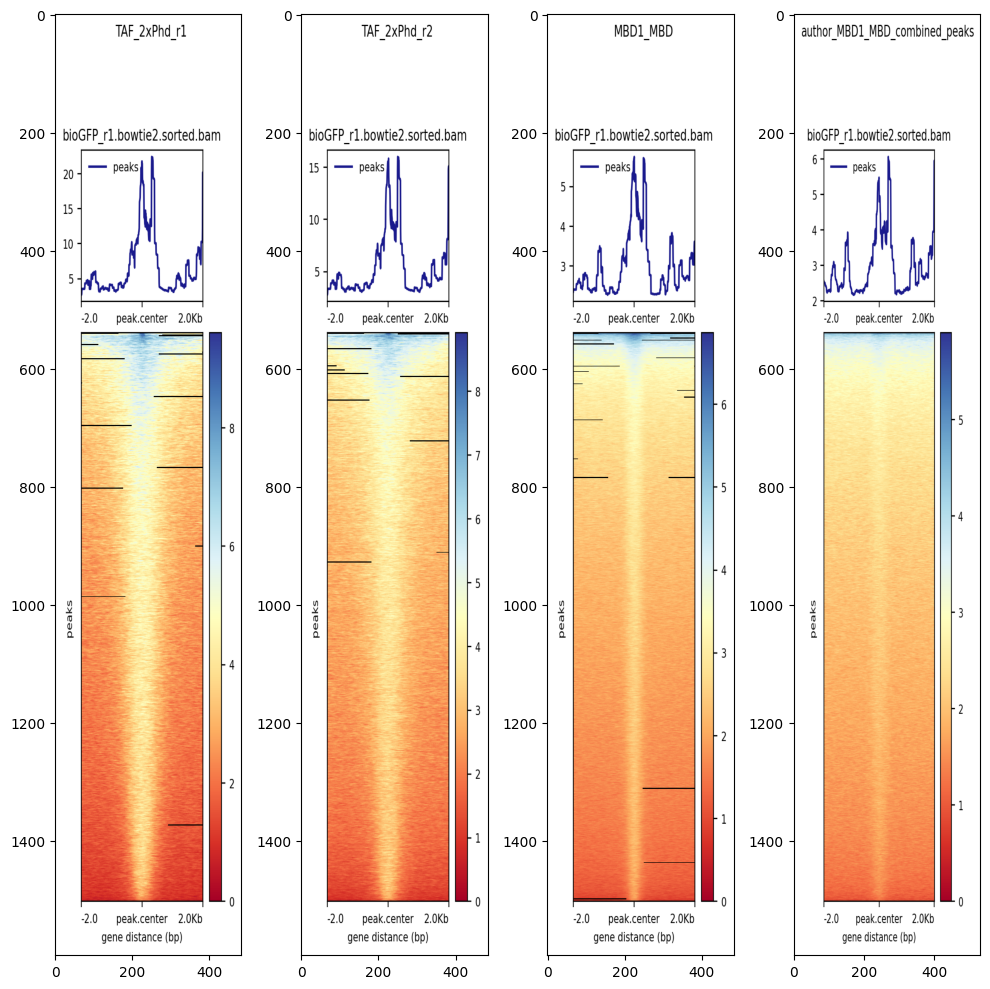

In [55]:
import os
import matplotlib.pyplot as plt

root_path="/network/projects/_groups/grn_control/bow/NanoTag/nanotag/heatmaps/peaks/"

fig, ax = plt.subplots(1, 4, figsize=(10, 10))

for plot_idx, png_filepath in enumerate(os.listdir(root_path)):
    # png_filepath =f"{root_path}/{sra}/{hist}_SEACR_heatmap.png"
    if not png_filepath.endswith("png"):
        continue
    png_filepath = f"{root_path}/{png_filepath}"
    print(png_filepath, os.path.exists(png_filepath))
    img = plt.imread(png_filepath)
    ax[plot_idx].imshow(img, aspect="auto") # , interpolation='nearest')
    # ax[plot_idx].set_title(hist)

fig.tight_layout()
fig.savefig("/network/projects/_groups/grn_control/bow/NanoTag/nanotag/heatmap_peaks.png") 
plt.show()

### Compare author peaks with replicated peaks

In [36]:
%%bash

author_beds=/network/projects/_groups/grn_control/bow/NanoTag/nanotag/data/polybox/mm10

# note it will replace the output file fix it!
intervene venn -i $author_beds/MBD1_MBD_combined_peaks_mm10_output.bed peaks/broadpeaks-to-bed/MBD1_peaks.broadPeak.bed

intervene venn -i $author_beds/TAF3-2xPHD_combined_peak_mm10_output.bed peaks/broadpeaks-to-bed/TAF3_2xPhd_r1_peaks.broadPeak.bed

intervene venn -i $author_beds/TAF3-2xPHD_combined_peak_mm10_output.bed peaks/broadpeaks-to-bed/TAF3_2xPhd_r2_peaks.broadPeak.bed

intervene venn -i $author_beds/TAF3-2xPHD_combined_peak_mm10_output.bed taf3_merged.bed


Generating a 2-way "venn" diagram. Please wait...


Done! Please check your results @ /network/projects/grn_control/bow/NanoTag/nanotag/Intervene_results. 
Thank you for using Intervene!



#### MBD1 & TAF3_r1 & TAF_r2:

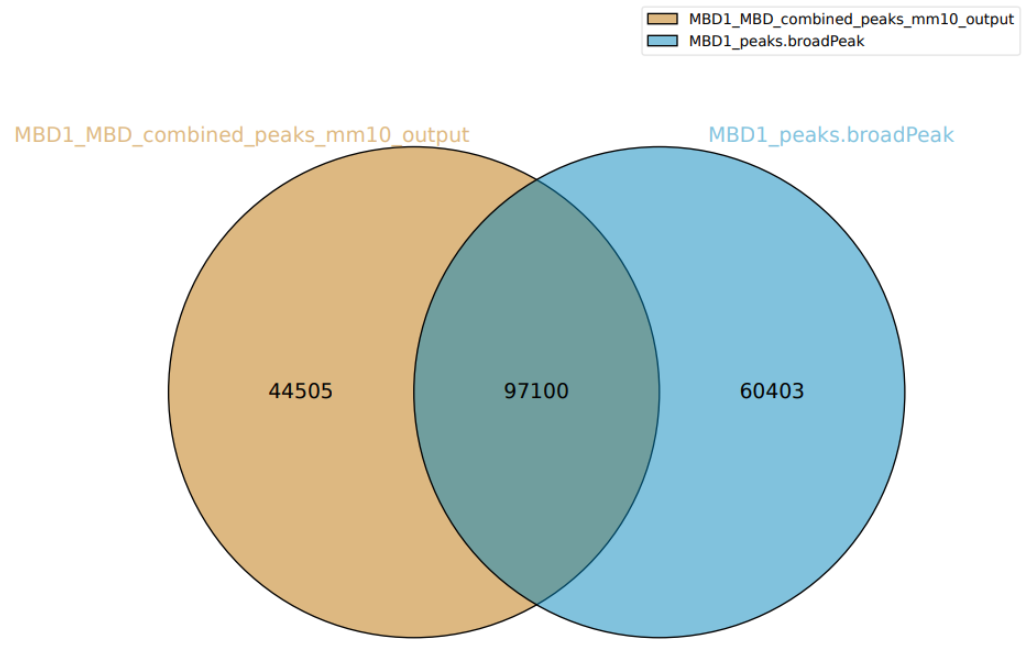<img src=attachment:902ce902-078b-4129-9b15-57418ad23120.png width="400"><img src=attachment:e12649bf-5038-4e39-8030-cf651a2d7fa6.png width="400">

<img src=attachment:4ecc6b59-8d0d-4316-a731-ba246a7d1be5.png width="500">

|peaks|similarity %|
|:--:|:--:|
|MBD1| 48%
|TAF3_r1|45%
|TAF3_r2|33%
|TAF3_merged|31%
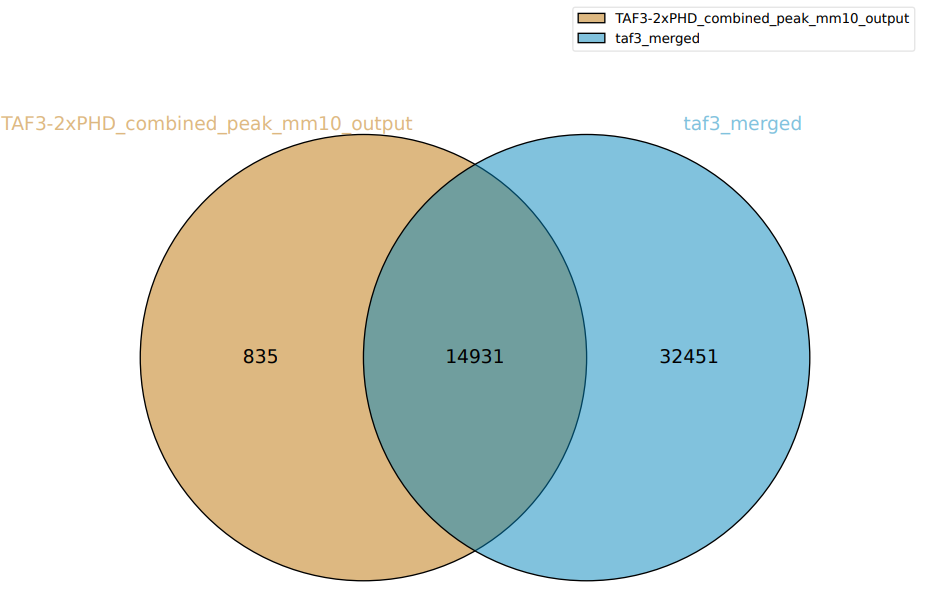
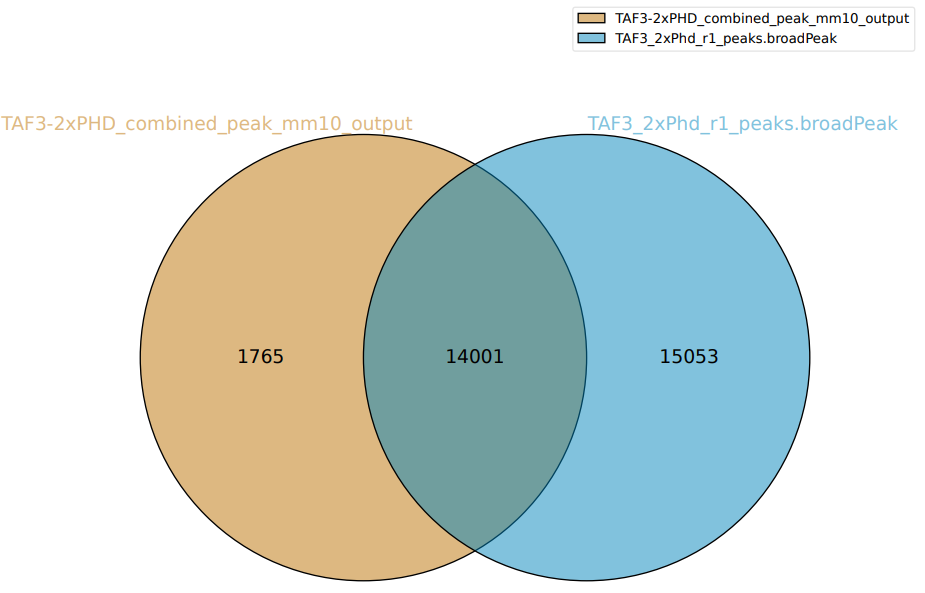
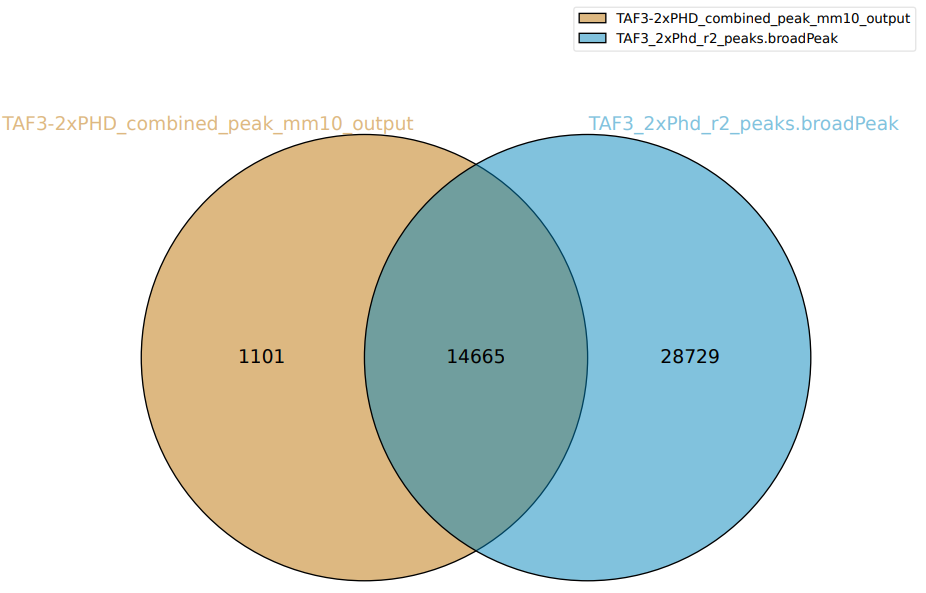

In [37]:
print(f"MBD1 similarity: {97100/(97100 + 44505 + 60403) * 100:.0f}%")
print(f"TAF3_r1 similarity: {14001/(14001 + 1765 + 15053) * 100:.0f}%")
print(f"TAF3_r2 similarity: {14665/(14665 + 1101 + 28729) * 100:.0f}%")
print(f"TAF3_merged similarity: {14931/(14931 + 835 + 32451) * 100:.0f}%")

MBD1 similarity: 48%
TAF3_r1 similarity: 45%
TAF3_r2 similarity: 33%
TAF3_merged similarity: 31%
